<a href="https://colab.research.google.com/github/thspanos/AI-LAb/blob/main/Thomas_Spanos_Tor_Hunting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#εγκατάσταση πακέτου tensorflow (hhttps://www.tensorflow.org/)
!pip install tensorflow
#εγκατάσταση πακέτου scikit-learn (https://scikit-learn.org/)
!pip install scikit-learn

In [2]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


In [3]:
def load_dataset(file_path):

    # 1) φόρτωση (κόβει το DtypeWarning για mixed types)
    df = pd.read_csv(file_path, low_memory=False)


    # Κωδικοποίηση Label-1 και Label-2 σε 0,1,2,...
    df['Label-1_code'], _ = pd.factorize(df['Label-1'])
    df['Label-2_code'], _ = pd.factorize(df['Label-2'])

    # Στόχος: Label-1_code (Tor κ.λπ.)
    TARGET_COL = 'Label-1_code'

 # 3) επιλέγουμε features: όλα εκτός των label-στηλών
    feature_df = df.drop(columns=['Label-1', 'Label-2', TARGET_COL], errors='ignore').copy()

    # 4) μετατροπή ΟΛΩΝ των features σε αριθμητικά (ό,τι δεν γίνεται -> NaN)
    for col in feature_df.columns:
        feature_df[col] = pd.to_numeric(feature_df[col], errors='coerce')

    # 5) καθαρισμός inf/-inf -> NaN
    feature_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # 6) συμπλήρωση NaN με median ανά στήλη (και αν κάποια στήλη έχει όλα NaN, θα μείνει NaN)
    med = feature_df.median(numeric_only=True)
    feature_df = feature_df.fillna(med)
    # ό,τι απέμεινε NaN (π.χ. στήλη που ήταν εξ ολοκλήρου μη-αριθμητική) -> 0
    feature_df = feature_df.fillna(0)

    # 7) X, y
    X = feature_df.values
    y = df[TARGET_COL].values

    # 8) (προαιρετικός τελικός καθαρισμός ασφαλείας)
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)


    #y = df[TARGET_COL].values

    # 4) μόνο αριθμητικές στήλες για X
    #X_num = df.select_dtypes(include=['number']).copy()

   # 5) καθάρισμα: inf/-inf -> NaN, και μετά NaN -> median στήλης
    #X_num = X_num.replace([np.inf, -np.inf], np.nan)
    #X_num = X_num.fillna(X_num.median(numeric_only=True))

    # 6) αφαιρούμε τη στήλη στόχο από τα features
    #X = X_num.drop(columns=[TARGET_COL], errors='ignore').values

    return X, y

In [4]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):

    model = Sequential([
        Input(shape=(input_dim,)),     # <-- ορίζουμε το input εδώ
        Dense(256, activation='relu'), # <-- χωρίς input_dim
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(4, activation='softmax') # <-- 4 outputs για Label-1_code
    ])



    #model = Sequential()
    #model.add(Dense(256, input_dim=input_dim, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(64, activation='relu'))
    # αύξηση των εξόδων σε 4
    #model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [9]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(csv_file_path, model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = load_dataset(csv_file_path)

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

                # --- IPS block
                y_pred = np.argmax(model.predict(X_test), axis=1)
                blocked_indices = np.where(y_pred == 1)[0] # 1=Tor
                if blocked_indices.size > 0:
                  print(f"Blocking {len(blocked_indices)} TOR traffic instances.")
                # --- IPS block ---


                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
    plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Batches')
    plt.legend()
    plt.show()

In [10]:
#θέση αρχείου csv με το σύνολο δεδομένων
csv_file_path = 'https://raw.githubusercontent.com/thspanos/AI-LAb/refs/heads/main/Data/DarkNet.csv'

In [11]:
#τυποποίηση (standardize) δεδομένων
scaler = StandardScaler()

In [12]:
#φόρτωση συνόλου δεδομένων
X, y = load_dataset(csv_file_path)
X = scaler.fit_transform(X)

In [13]:
#εκπαίδευση μοντέλου
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = create_and_train_model(X_train.shape[1])

NameError: name 'Input' is not defined

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7067 - loss: 0.7350
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8565 - loss: 0.3631
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8738 - loss: 0.3141
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8874 - loss: 0.2786
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8918 - loss: 0.2636
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Batch 800, Training Accuracy: 0.9175, Test Accuracy: 0.9148
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7054 - loss: 0.7231
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8548 - loss: 0.3641
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8696 - loss: 0.3206
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8792 - loss: 0.2947
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8897 - loss: 0.2652
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Batch 1600, Training Accuracy: 0.9123, Test Accuracy: 0.9092
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7154 - loss: 0.6979
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8549 - loss: 0.3604
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8721 - loss: 0.3172
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8836 - loss: 0.2901
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8865 - loss: 0.2769
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Batch 2400, Training Accuracy: 0.9116, Test Accuracy: 0.9069
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7160 - loss: 0.7020
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8518 - loss: 0.3632
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8733 - loss: 0.3168
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8844 - loss: 0.2866
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8898 - loss: 0.2681
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Batch 3200, Training Accuracy: 0.9171, Test Accuracy: 0.9146
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7158 - loss: 0.7021
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8567 - loss: 0.3588
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8770 - loss: 0.3062
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8832 - loss: 0.2840
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8950 - loss: 0.2659
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 4000, Training Accuracy: 0.9224, Test Accuracy: 0.9185
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7140 - loss: 0.7087
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8476 - loss: 0.3743
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8728 - loss: 0.3186
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8839 - loss: 0.2845
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8921 - loss: 0.2693
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 4800, Training Accuracy: 0.9151, Test Accuracy: 0.9123
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7135 - loss: 0.7058
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8565 - loss: 0.3677
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8734 - loss: 0.3154
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8834 - loss: 0.2864
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8921 - loss: 0.2614
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Batch 5600, Training Accuracy: 0.9129, Test Accuracy: 0.9109
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7111 - loss: 0.7055
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8543 - loss: 0.3608
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8750 - loss: 0.3153
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8881 - loss: 0.2789
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8918 - loss: 0.2612
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Batch 6400, Training Accuracy: 0.9177, Test Accuracy: 0.9133
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7156 - loss: 0.7002
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8566 - loss: 0.3556
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8724 - loss: 0.3109
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8872 - loss: 0.2829
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8924 - loss: 0.2672
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Batch 7200, Training Accuracy: 0.9169, Test Accuracy: 0.9130
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


858/858 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7102 - loss: 0.7139
Epoch 2/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8550 - loss: 0.3697
Epoch 3/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8728 - loss: 0.3145
Epoch 4/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8810 - loss: 0.2891
Epoch 5/5
858/858 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8892 - loss: 0.2683
1715/1715 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
429/429 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Batch 8000, Training Accuracy: 0.9165, Test Accuracy: 0.9136


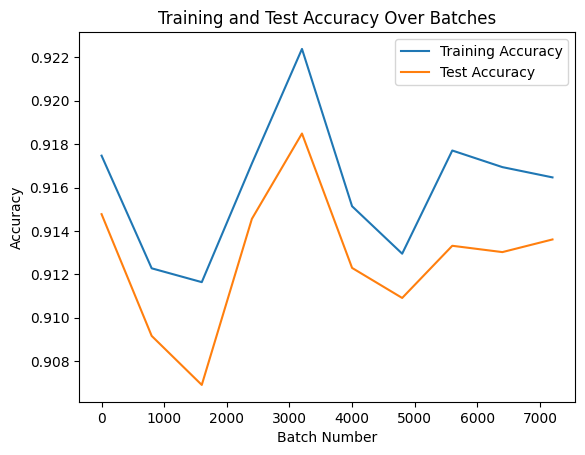

In [11]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
simulate_streaming_lambda_architecture(csv_file_path, model, scaler)